# EONIA curve bootstrapping

In the next notebooks, I'll reproduce the results of the paper by F. M. Ametrano and M. Bianchetti, _Everything You Always Wanted to Know About Multiple Interest Rate Curve Bootstrapping but Were Afraid to Ask_ (April 2, 2013). The paper is available at SSRN: http://ssrn.com/abstract=2219548.

In [1]:
%matplotlib inline
import math
import utils

In [2]:
from QuantLib import *

In [3]:
today = Date(11, December, 2012)
Settings.instance().evaluationDate = today

#### First try

We start by instantiating helpers for all the rates used in the bootstrapping process, as reported in figure 25 of the paper.

The first three instruments are three 1-day deposit that give us discounting between today and the day after spot. They are modeled by three instances of the `DepositRateHelper` class with a tenor of 1 day and a number of fixing days going from 0 (for the deposit starting today) to 2 (for the deposit starting on the spot date).

In [4]:
helpers = [ DepositRateHelper(QuoteHandle(SimpleQuote(rate/100)),
                              Period(1,Days), fixingDays,
                              TARGET(), Following, False, Actual360())
            for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)] ]

Then, we have a series of OIS quotes for the first month. They are modeled by instances of the `OISRateHelper` class with varying tenors. They also require an instance of the `Eonia` class, which doesn't need a forecast curve and can be shared between the helpers.

In [5]:
eonia = Eonia()

In [6]:
helpers += [ OISRateHelper(2, Period(*tenor),
                           QuoteHandle(SimpleQuote(rate/100)), eonia)
             for rate, tenor in [(0.070, (1,Weeks)), (0.069, (2,Weeks)),
                                 (0.078, (3,Weeks)), (0.074, (1,Months))] ]

Next, five OIS forwards on ECB dates. For these, we need to instantiate the `DatedOISRateHelper` class and specify start and end dates explicitly.

In [7]:
helpers += [ DatedOISRateHelper(start_date, end_date,
                                QuoteHandle(SimpleQuote(rate/100)), eonia)
             for rate, start_date, end_date in [
                 (0.046, Date(16,January,2013), Date(13,February,2013)),
                 (0.016, Date(13,February,2013), Date(13,March,2013)),
                 (-0.007, Date(13,March,2013), Date(10,April,2013)),
                 (-0.013, Date(10,April,2013), Date(8,May,2013)),
                 (-0.014, Date(8,May,2013), Date(12,June,2013))] ]

Finally, we add OIS quotes up to 30 years.

In [8]:
helpers += [ OISRateHelper(2, Period(*tenor),
                           QuoteHandle(SimpleQuote(rate/100)), eonia)
             for rate, tenor in [(0.002, (15,Months)), (0.008, (18,Months)),
                                 (0.021, (21,Months)), (0.036, (2,Years)),
                                 (0.127, (3,Years)), (0.274, (4,Years)),
                                 (0.456, (5,Years)), (0.647, (6,Years)),
                                 (0.827, (7,Years)), (0.996, (8,Years)),
                                 (1.147, (9,Years)), (1.280, (10,Years)),
                                 (1.404, (11,Years)), (1.516, (12,Years)),
                                 (1.764, (15,Years)), (1.939, (20,Years)),
                                 (2.003, (25,Years)), (2.038, (30,Years))] ]

The curve is an instance of `PiecewiseLogCubicDiscount` (corresponding to the `PiecewiseYieldCurve<Discount,LogCubic>` class in C++; I won't repeat the argument for this choice made in section 4.5 of the paper).  We let the reference date of the curve move with the global evaluation date, by specifying it as 0 days after the latter on the TARGET calendar.  The day counter chosen is not of much consequence, as it is only used internally to convert dates into times. Also, we enable extrapolation beyond the maturity of the last helper; that is mostly for convenience as we retrieve rates to plot the curve near its far end.

In [9]:
eonia_curve_c = PiecewiseLogCubicDiscount(0, TARGET(),
                                          helpers, Actual365Fixed())
eonia_curve_c.enableExtrapolation()

To compare the curve with the one shown in figure 26 of the paper, we can retrieve daily overnight rates over its first two years and plot them:

In [10]:
today = eonia_curve_c.referenceDate()
end = today + Period(2,Years)
dates = [ Date(serial) for serial in range(today.serialNumber(),
                                           end.serialNumber()+1) ]
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days),
                                      Actual360(), Simple).rate()
            for d in dates ]

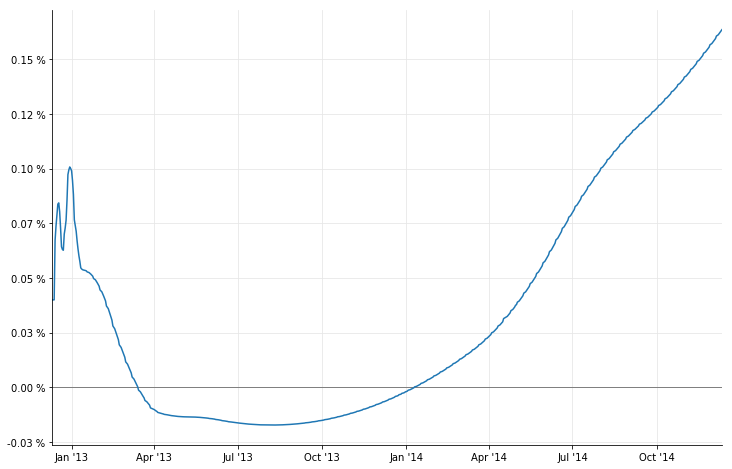

In [11]:
_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(rates_c,'-')], format_rates=True)

However, we still have work to do. Out plot above shows a rather large bump at the end of 2012 which is not present in the paper. To remove it, we need to model properly the turn-of-year effect.

#### Turn-of-year jumps

As explained in section 4.8 of the paper, the turn-of-year effect is a jump in interest rates due to an increased demand for liquidity at the end of the year.  The jump is embedded in any quoted rates that straddles the end of the year and must be treated separately; the `YieldTermStructure` class allows this by taking any number of jumps, modeled as additional discount factors, and applying them at the specified dates.

Our problem is to estimate the size of the jump. To simplify analysis, we turn to flat forward rates instead of log-cubic discounts; thus, we instantiate a `PiecewiseFlatForward` curve (corresponding to `PiecewiseYieldCurve<ForwardRate,BackwardFlat>` in C++).

In [12]:
eonia_curve_ff = PiecewiseFlatForward(0, TARGET(),
                                      helpers, Actual365Fixed())
eonia_curve_ff.enableExtrapolation()

To show the jump more clearly, I'll restrict the plot to the first 6 months:

In [13]:
end = today + Period(6,Months)
dates = [ Date(serial) for serial in range(today.serialNumber(),
                                           end.serialNumber()+1) ]
rates_ff = [ eonia_curve_ff.forwardRate(d, TARGET().advance(d,1,Days),
                                        Actual360(), Simple).rate()
             for d in dates ]

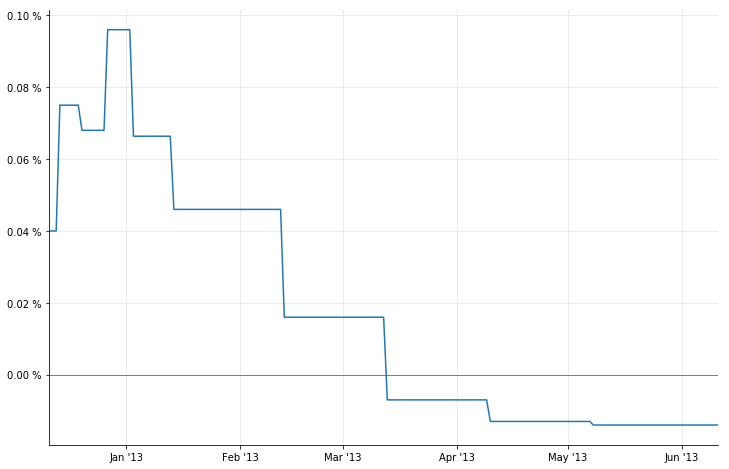

In [14]:
_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(rates_ff,'-')], format_rates=True)

As we see, the forward ending at the beginning of January 2013 is out of line. In order to estimate the jump, we need to estimate a "clean" forward that doesn't include it.

A possible estimate (although not the only one) can be obtained by interpolating the forwards around the one we want to replace. To do so, we extract the values of the forwards rates and their corresponding dates.

In [15]:
nodes = list(eonia_curve_ff.nodes())

If we look at the first few nodes, we can clearly see that the seventh is out of line.

In [16]:
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.0009732981324671213),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

To create a curve that doesn't include the jump, we replace the relevant forward rate with a simple average of the ones that precede and follow...

In [17]:
nodes[6] = (nodes[6][0], (nodes[5][1]+nodes[7][1])/2.0)
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.000681123301587661),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

...and instantiate a `ForwardCurve` with the modified nodes.

In [18]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ForwardCurve(temp_dates, temp_rates,
                          eonia_curve_ff.dayCounter())

For illustration, we can extract daily overnight nodes from the doctored curve and plot them alongside the old ones:

In [19]:
temp_rates = [ temp_curve.forwardRate(d, TARGET().advance(d,1,Days),
                                      Actual360(), Simple).rate()
               for d in dates ]

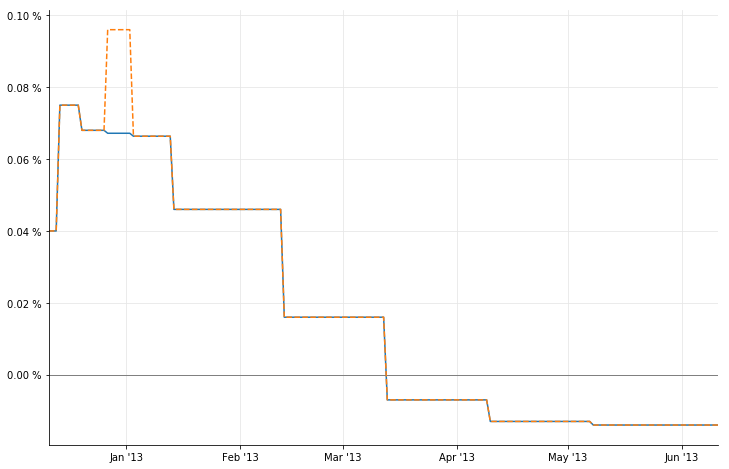

In [20]:
_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(temp_rates,'-'), (rates_ff,'--')], format_rates=True)

Now we can estimate the size of the jump. As the paper hints, it's more an art than a science. I've been able to reproduce closely the results of the paper by extracting from the two curves the forward rate over the two weeks around the end of the year:

In [21]:
d1 = Date(31,December,2012) - Period(1,Weeks)
d2 = Date(31,December,2012) + Period(1,Weeks)

In [22]:
F = eonia_curve_ff.forwardRate(d1, d2, Actual360(), Simple).rate()
F_1 = temp_curve.forwardRate(d1, d2, Actual360(), Simple).rate()
print(utils.format_rate(F,digits=3))
print(utils.format_rate(F_1,digits=3))

0.082 %
0.067 %


We want to attribute the whole jump to the last day of the year, so we rescale it according to

$$
(F-F_1) \cdot t_{12} = J \cdot t_J
$$

where $t_{12}$ is the time between the two dates and $t_J$ is the time between the start and end date of the end-of-year overnight deposit. This gives us a jump quite close to the value of 10.2 basis points reported in the paper.

In [23]:
t12 = eonia_curve_ff.dayCounter().yearFraction(d1,d2)
t_j = eonia_curve_ff.dayCounter().yearFraction(Date(31,December,2012),
                                               Date(2,January,2013))
J = (F-F_1)*t12/t_j
print(utils.format_rate(J,digits=3))

0.101 %


As I mentioned previously, the jump can be added to the curve as a corresponding discount factor $1/(1+J \cdot t_J)$ on the last day of the year.  The information can be passed to the curve constructor, giving us a new instance:

In [24]:
B = 1.0/(1.0+J*t_j)
jumps = [QuoteHandle(SimpleQuote(B))]
jump_dates = [Date(31,December,2012)]
eonia_curve_j = PiecewiseFlatForward(0, TARGET(),
                                     helpers, Actual365Fixed(),
                                     jumps, jump_dates)

Retrieving daily overnight rates from the new curve and plotting them, we can see the jump quite clearly:

In [25]:
rates_j = [ eonia_curve_j.forwardRate(d, TARGET().advance(d,1,Days),
                                      Actual360(), Simple).rate()
            for d in dates ]

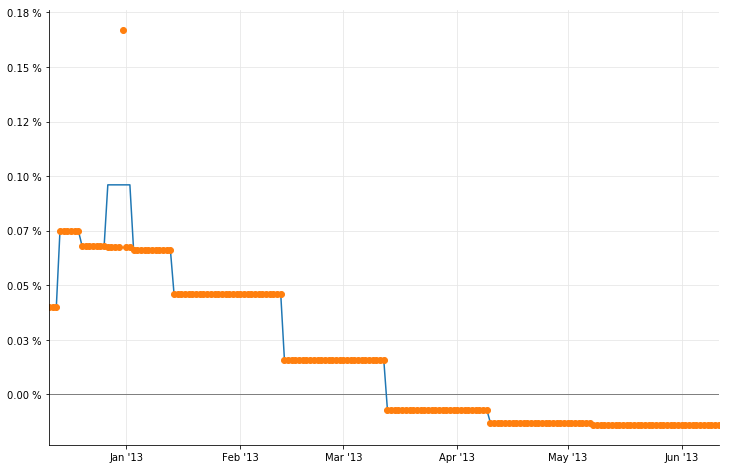

In [26]:
_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(rates_ff,'-'), (rates_j,'o')], format_rates=True)

We can now go back to log-cubic discounts and add the jump.

In [27]:
eonia_curve = PiecewiseLogCubicDiscount(0, TARGET(),
                                        helpers, Actual365Fixed(),
                                        jumps, jump_dates)
eonia_curve.enableExtrapolation()

In [28]:
rates_c = [ eonia_curve_c.forwardRate(d, TARGET().advance(d,1,Days),
                                      Actual360(), Simple).rate()
            for d in dates ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days),
                                  Actual360(), Simple).rate()
          for d in dates ]

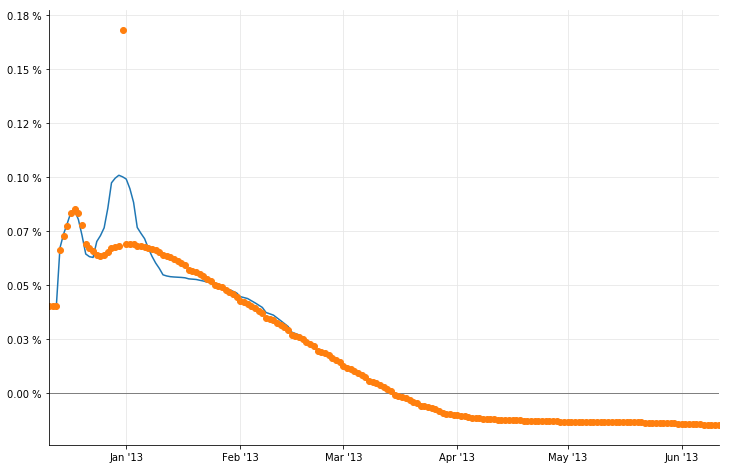

In [29]:
_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(rates_c,'-'), (rates,'o')], format_rates=True)

As you can see, the large bump is gone now.  The two plots in figure 26 can be reproduced as follows (omitting the jump at the end of 2013 for brevity, and the flat forwards for clarity):

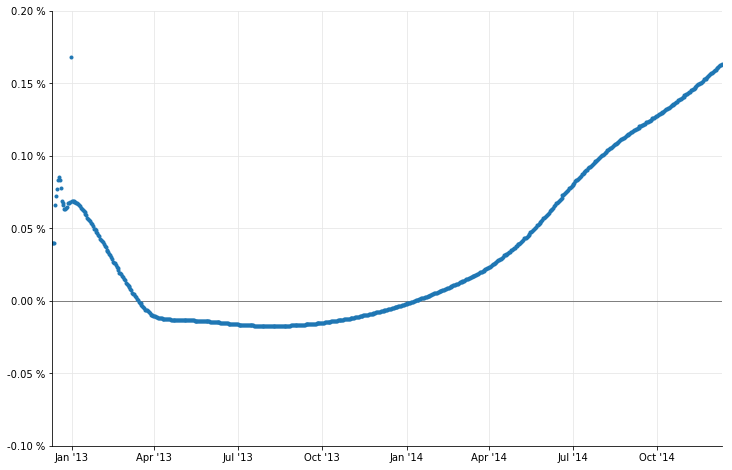

In [30]:
dates = [ today+Period(i,Days) for i in range(0, 365*2+1) ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days),
                                  Actual360(), Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.highlight_x_axis(ax)
utils.plot_curve(ax, dates, [(rates,'.')], ymin=-0.001, ymax=0.002, format_rates=True)

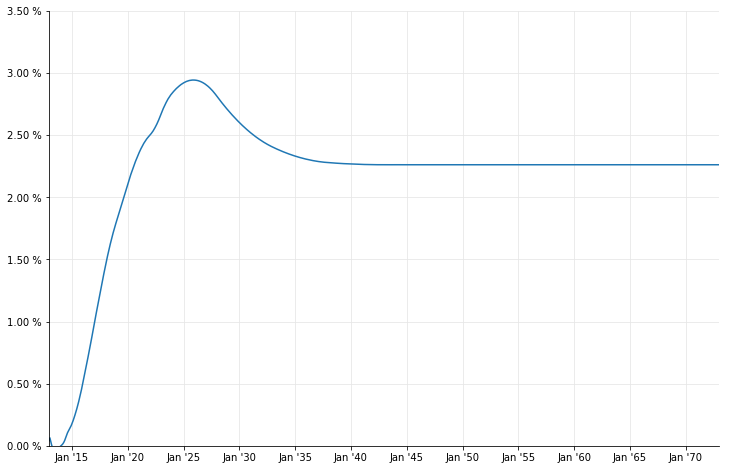

In [31]:
dates = [ today+Period(i,Months) for i in range(0, 12*60+1) ]
rates = [ eonia_curve.forwardRate(d, TARGET().advance(d,1,Days),
                                  Actual360(), Simple).rate()
          for d in dates ]
_, ax = utils.plot()
utils.plot_curve(ax, dates, [(rates,'-')], ymin=0.0, ymax=0.035, format_rates=True)

A final word of warning: as you saw, the estimate of the jumps is not an exact science, so it's best to check it manually and not to leave it to an automated procedure.

Moreover, jumps nowadays might be present at the end of each month, as reported for instance in [Paolo Mazzocchi's presentation at the QuantLib User Meeting 2014](https://speakerdeck.com/nando1970/eonia-jumps-and-proper-euribor-forwarding). This, too, suggests particular care in building the Eonia curve.